# Praktikum 1

## Setup

In [1]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [2]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Setup input pipeline

In [3]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to C:\Users\HP Pavilion\tensorflow_datasets\imdb_reviews\plain_text\1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [4]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [5]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])


texts:  [b"Seriously, I absolutely love these old movies and their simplicity but I just watched this for the first time last night and it easily slotted itself into my bottom five of all time. Was this supposed to be about the love story or the zombies??? This movie was so bad that after it mercifully ended all I could do is laugh at how ridiculously bad it really was. Thankfully I'm too anal to turn a movie off without seeing the entire thing or I wouldn't be able to brag about watching this all the way through in one sitting! I like to think something positive can be said about anything in life so in keeping with that theory I will acknowledge this film's most positive asset, it was very short for a full length film."
 b'I think this show is screamingly funny! It\'s not for every taste, and I\'m not going to elevate or denigrate the folks that don\'t get it. I\'m sure they\'re wonderful bright people that operate at a different wavelength. But if you like it, you REALLY like it. Sar

## Buat Teks Encoder

In [6]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [7]:
vocab=np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [8]:
encoded_example=encoder(example)[:3].numpy()
encoded_example

array([[633,  10, 412, ...,   0,   0,   0],
       [ 10, 103,  11, ...,   0,   0,   0],
       [697,   2, 213, ...,   0,   0,   0]], dtype=int64)

In [9]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"Seriously, I absolutely love these old movies and their simplicity but I just watched this for the first time last night and it easily slotted itself into my bottom five of all time. Was this supposed to be about the love story or the zombies??? This movie was so bad that after it mercifully ended all I could do is laugh at how ridiculously bad it really was. Thankfully I'm too anal to turn a movie off without seeing the entire thing or I wouldn't be able to brag about watching this all the way through in one sitting! I like to think something positive can be said about anything in life so in keeping with that theory I will acknowledge this film's most positive asset, it was very short for a full length film."
Round-trip:  seriously i absolutely love these old movies and their [UNK] but i just watched this for the first time last night and it easily [UNK] itself into my [UNK] five of all time was this supposed to be about the love story or the [UNK] this movie was so bad t

## Buat Model

In [10]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [11]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [12]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 6s 6s/step
[0.00549882]


In [13]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 165ms/step
[0.00549882]


In [14]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Train Model

In [15]:
history = model.fit(train_dataset, epochs=10,validation_data=test_dataset, validation_steps=30)

Epoch 1/10


391/391 [==============================] - 63s 143ms/step - loss: 0.6346 - accuracy: 0.5782 - val_loss: 0.4630 - val_accuracy: 0.7703
Epoch 2/10
391/391 [==============================] - 55s 140ms/step - loss: 0.3899 - accuracy: 0.8235 - val_loss: 0.3638 - val_accuracy: 0.8385
Epoch 3/10
391/391 [==============================] - 53s 135ms/step - loss: 0.3403 - accuracy: 0.8495 - val_loss: 0.3442 - val_accuracy: 0.8479
Epoch 4/10
391/391 [==============================] - 53s 135ms/step - loss: 0.3201 - accuracy: 0.8587 - val_loss: 0.3294 - val_accuracy: 0.8531
Epoch 5/10
391/391 [==============================] - 56s 144ms/step - loss: 0.3108 - accuracy: 0.8652 - val_loss: 0.3233 - val_accuracy: 0.8531
Epoch 6/10
391/391 [==============================] - 59s 151ms/step - loss: 0.3084 - accuracy: 0.8659 - val_loss: 0.3251 - val_accuracy: 0.8552
Epoch 7/10
391/391 [==============================] - 59s 151ms/step - loss: 0.3068 - accuracy: 0.8677 - val_loss: 0.3217 - val_accuracy: 0.8

In [16]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 25s 63ms/step - loss: 0.3215 - accuracy: 0.8482
Test Loss: 0.32148388028144836
Test Accuracy: 0.8482000231742859


(0.0, 0.6514309868216515)

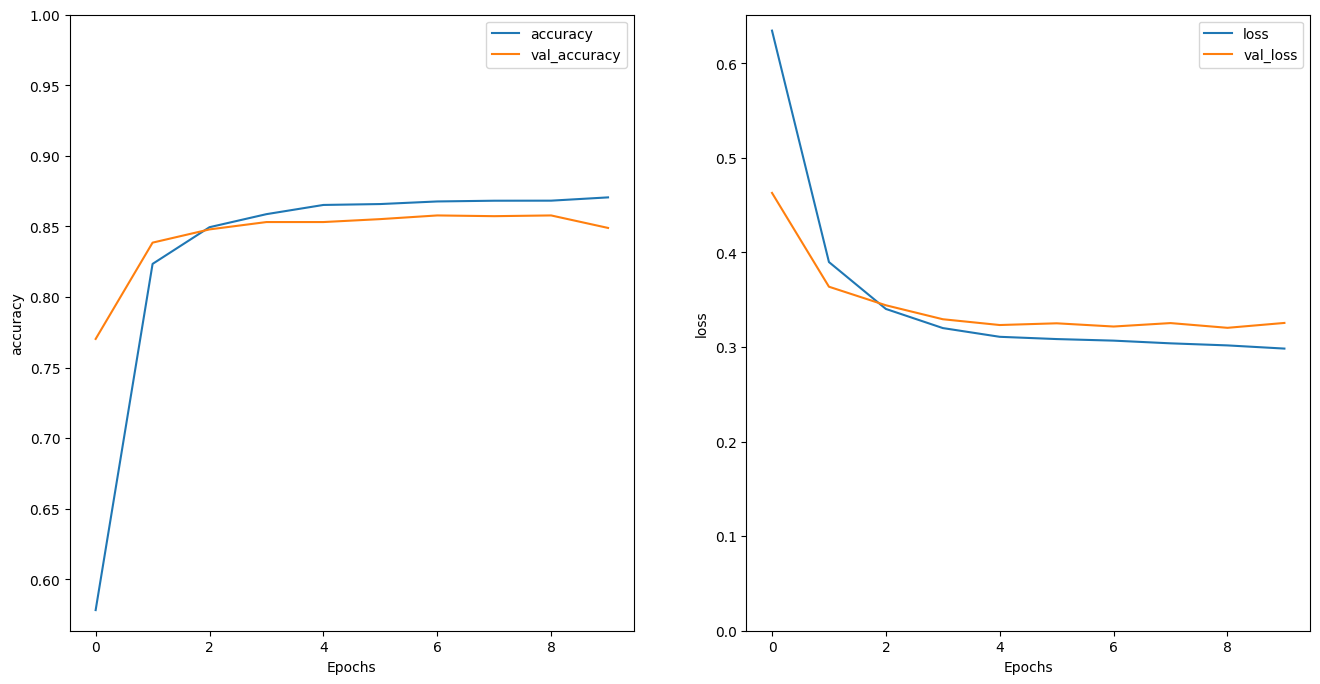

In [17]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [18]:
sample_text = ('The movie was cool. The animation and the graphics were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 2s 2s/step


## Stack two or more LSTM layers

In [19]:
model = tf.keras.Sequential([encoder,
tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
tf.keras.layers.Dense(64, activation='relu'),
tf.keras.layers.Dropout(0.5),
tf.keras.layers.Dense(1)
])

In [20]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
optimizer=tf.keras.optimizers.Adam(1e-4),
metrics=['accuracy'])

In [21]:
history = model.fit(train_dataset, epochs=10,
validation_data=test_dataset,
validation_steps=30)

Epoch 1/10


391/391 [==============================] - 109s 248ms/step - loss: 0.6225 - accuracy: 0.5880 - val_loss: 0.4261 - val_accuracy: 0.8078
Epoch 2/10
391/391 [==============================] - 92s 236ms/step - loss: 0.3810 - accuracy: 0.8346 - val_loss: 0.3457 - val_accuracy: 0.8510
Epoch 3/10
391/391 [==============================] - 101s 260ms/step - loss: 0.3378 - accuracy: 0.8550 - val_loss: 0.3350 - val_accuracy: 0.8568
Epoch 4/10
391/391 [==============================] - 106s 272ms/step - loss: 0.3199 - accuracy: 0.8639 - val_loss: 0.3210 - val_accuracy: 0.8562
Epoch 5/10
391/391 [==============================] - 101s 257ms/step - loss: 0.3123 - accuracy: 0.8657 - val_loss: 0.3251 - val_accuracy: 0.8542
Epoch 6/10
391/391 [==============================] - 94s 242ms/step - loss: 0.3125 - accuracy: 0.8654 - val_loss: 0.3261 - val_accuracy: 0.8609
Epoch 7/10
391/391 [==============================] - 94s 241ms/step - loss: 0.3045 - accuracy: 0.8694 - val_loss: 0.3295 - val_accuracy:

In [22]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 47s 120ms/step - loss: 0.3259 - accuracy: 0.8437
Test Loss: 0.3259051442146301
Test Accuracy: 0.8436800241470337


In [23]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 5s 5s/step
[[-2.1549692]]


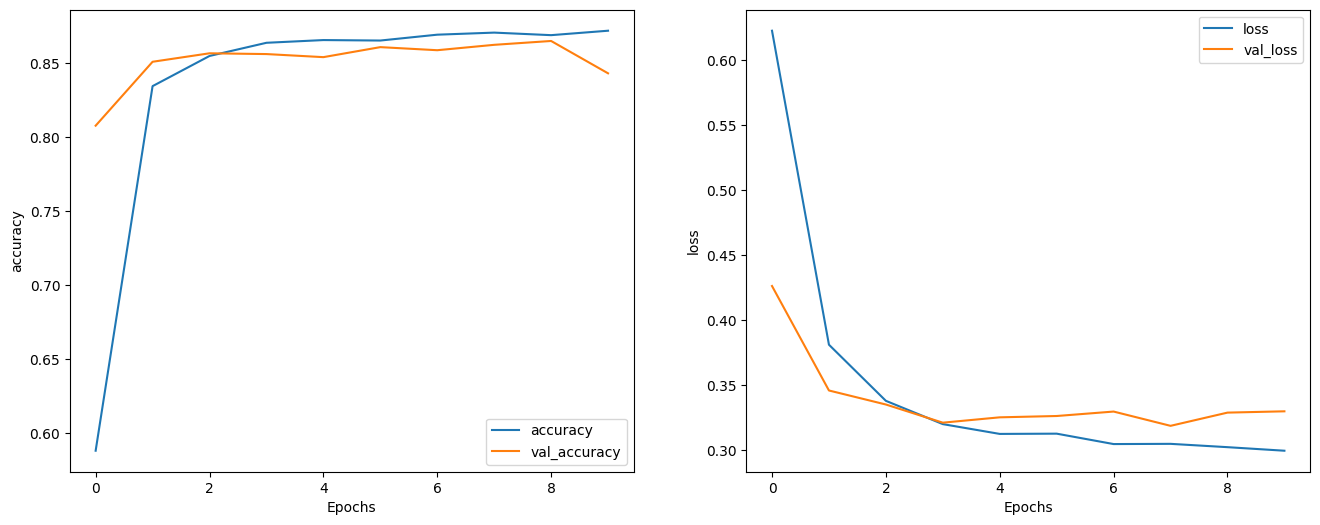

In [24]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')